In [3]:
import numpy as np
from scipy.stats import norm
from scipy.stats import uniform
import matplotlib.pyplot as plt
import math
import random

### 1. Initialize the relevant parameters

In [4]:
#Share information

sigma = 0.25
r = 0.1
S0 = 120

#Option information
T = 2
K = 1000
k_log = np.log(K)


### 2. Calculate the analytics price for the put option in the close-form

In [5]:
#Determining the analytical solution

def put_analytical_price(S0,K,r,T):
    d_1 = (np.log(S0/K)+(r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d_2 = d_1 - sigma*np.sqrt(T)
    mput_analytic = K*math.exp(-r*T)*norm.cdf(-d_2) - S0*norm.cdf(-d_1)
    return mput_analytic


mput_analytic = put_analytical_price(S0,K,r,T)

print('The fourier estimation using Black-Scholes function is {}'.format(mput_analytic))

The fourier estimation using Black-Scholes function is 698.7307536073846


### 3. Calculate the analytics price using characteristic function


In [6]:
#Choosing t_max and N

t_max = 20
N = 200


#Characteristic functions

def char_function(S_0, r, sigma, T, t_max,N):
    
    k_log = np.log(K)
    
    def c_M1(t):
        return np.exp(1j*t*(np.log(S0) + (r-sigma**2/2)*T) - ( sigma**2)*T*(t**2)/2)

    def c_M2(t):
        return np.exp(1j*t*sigma**2*T)*c_M1(t)

    #Calculating delta and contructing t_n
    delta_t = t_max / N
    from_1_to_N = np.linspace(1,N,N)
    t_n = (from_1_to_N - 1/2)*delta_t

    #Approximate integral estimates

    first_integral  = sum(((( np.exp(-1j*t_n*k_log)*c_M2(t_n)).imag)/t_n)*delta_t)
    second_integral = sum(((( np.exp(-1j*t_n*k_log)*c_M1(t_n)).imag)/t_n)*delta_t)

    
    #Fourier put price

    fourier_call_val =  S0*(1/2 + first_integral/np.pi) - np.exp(-r*T)*K*(1/2 + second_integral / np.pi)
    
    fourier_put_val = K*np.exp(-r*T)+ fourier_call_val - S0
    
    return fourier_put_val
    
fourier_put_char = char_function(S0,r,sigma,T,t_max,N)

print('The fourier estimation using characteristic function is {}'.format(fourier_put_char))

The fourier estimation using characteristic function is 698.7307536073577


### 4. Calculate the put option using COS method

The fourier estimation using characteristic function is 698.7306714474088


[]

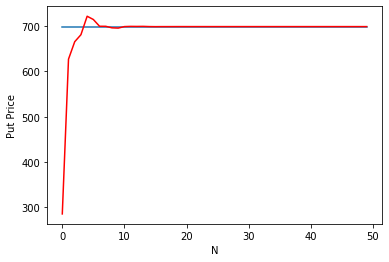

In [7]:
def upsilon_n(b1,b2,d,c,n):
        npi_d = np.pi*n*(d-b1) / (b2-b1)
        npi_c = np.pi*n*(c-b1) / (b2-b1)
        val_one = (np.cos(npi_d)*np.exp(d) - np.cos(npi_c)*np.exp(c))
        val_two = (n*np.pi*(np.sin(npi_d)*np.exp(d) - np.sin(npi_c)*np.exp(c))/ (b2-b1))
        return (val_one + val_two ) / ( 1+(n*np.pi/(b2-b1))**2)

def psi_n(b1,b2,d,c,n):
    if n == 0:
        return d-c 
    else:
        return (b2-b1)*(np.sin(n*np.pi*(d-b1)/(b2-b1)) - np.sin(n*np.pi*(c-b1)/(b2-b1)))/(n*np.pi)

def v_n(K,b1,b2,n):
    return 2*K*(upsilon_n(b2,b1,b2,0,n) -  psi_n(b2,b1,b2,0,n))/(b1-b2)

def logchar_func(u,S0,r,sigma,K,T):
    return np.exp(1j*u*(np.log(S0/K)+(r-sigma**2/2)*T) - (sigma**2)*T*(u**2)/2)

def put_price(N,S0,sigma,r,K,T,b2,b1):
    price = v_n(K,b2,b1,0)*logchar_func(0,S0,r,sigma,K,T)/2
    for n in range(1,N):
        price = price + logchar_func(n*np.pi/(b2-b1),S0,r,sigma,K,T)*np.exp(-1j*n*np.pi*b1/(b2-b1))*v_n(K,b2,b1,n)
    return price.real*np.exp(-r*T)

# b1,b2 for call

c1 = r
c2 = T*sigma**2
c4 = 0
L = 10

b1 = c1 - L*np.sqrt(c2-np.sqrt(c4))
b2 = c1 + L*np.sqrt(c2-np.sqrt(c4))
  
# Calculating COS for various N

COS_putprice =[None]*50

for i in range(1,51):
    COS_putprice[i-1] = put_price(i,S0,sigma,r,K,T,b2,b1)

print('The fourier estimation using characteristic function is {}'.format(COS_putprice[-1]))   
    
#Plotting the graph
plt.plot([mput_analytic]*50)
plt.plot(COS_putprice,'r')
plt.xlabel("N")
plt.ylabel("Put Price")
plt.plot()


### 5.  Use the fast fourier transform (FFT)

In [6]:
N = 2**10
delta = 0.25
alpha = -2

[]

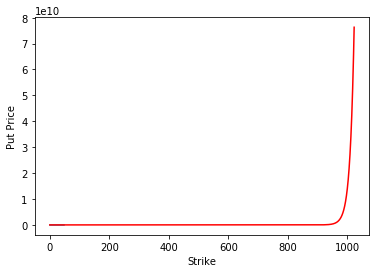

In [7]:
def log_char(u):
    return np.exp(1j*u*(np.log(S0))+  (r-sigma**2/2)*T - sigma**2*T*u**2/2)

def c_func(v):
    val1 = np.exp(-r*T)*log_char(v-(alpha+1)*1j)
    val2 = alpha**2 + alpha - v**2 +1j*(2*alpha+1)*v
    return val1/val2

n = np.array(range(N))
delta_k = 2*np.pi/(N*delta)
b = delta_k*(N-1/2)

log_strike = np.linspace(-b,b,N)

x = np.exp(1j*b*n*delta)*c_func(n*delta)*delta
x[0] = x[0]*0.5
x[-1] = x[-1]*0.5

xhat = np.fft.fft(x).real

fff_call =np.exp(-alpha*log_strike)*xhat/np.pi

#Plotting the graph
plt.plot([mput_analytic]*50)
plt.plot(fff_call,'r')
plt.xlabel("Strike")
plt.ylabel("Put Price")
plt.plot()